# NanoPyx "Codeless" Jupyter Notebook

This notebook allows you to generate a super-resolution image using SRRF (Super-Resolution Radiality Fluctuations) and then assess quality control metrics such as an Error Map (NanoJ-SQUIRREL), FRC (Fourier Ring Correlation) and Decorrelation analysis.

To use this notebook you don't need to interact with any code, just run cells in order and a graphical user interface will pop-up showcasing the parameters for each step.
When running this notebook on Colab, it will automatically prompt you to connect to your google Drive, from where you can select the input data.
To save the output of this notebook, make sure to select the "save output" option. Output will be saved on the same directory as the loaded image. If using an example dataset it will be saved on the path Python is currently running (if locally running the notebook) or on Colab files (if running on Colab, files button on the left bar).
If you found this work useful for your research please consider citing our [preprint](https://www.biorxiv.org/content/10.1101/2023.08.13.553080v1)  and out Github repo [![DOI](https://zenodo.org/badge/505388398.svg)](https://zenodo.org/badge/latestdoi/505388398)

**SRRF**: Culley S, Tosheva KL, Matos Pereira P, Henriques R. SRRF: Universal live-cell super-resolution microscopy. Int J Biochem Cell Biol. 2018 Aug;101:74-79. doi: 10.1016/j.biocel.2018.05.014. Epub 2018 May 28. PMID: 29852248; PMCID: PMC6025290. 

**Error Map**: Culley, S., Albrecht, D., Jacobs, C. et al. Quantitative mapping and minimization of super-resolution optical imaging artifacts. Nat Methods 15, 263–266 (2018). https://doi.org/10.1038/nmeth.4605

**FRC**: Nieuwenhuizen RP, Lidke KA, Bates M, Puig DL, Grünwald D, Stallinga S, Rieger B. Measuring image resolution in optical nanoscopy. Nat Methods. 2013 Jun;10(6):557-62. doi: 10.1038/nmeth.2448. Epub 2013 Apr 28. PMID: 23624665; PMCID: PMC4149789.

**DecorrAnalysis**: Descloux A, Grußmayer KS, Radenovic A. Parameter-free image resolution estimation based on decorrelation analysis. Nat Methods. 2019 Sep;16(9):918-924. doi: 10.1038/s41592-019-0515-7. Epub 2019 Aug 26. PMID: 31451766.  




In [ ]:
#@title Fix numpy version in Google Colab, can be skipped if running in local environment. Session will now restart automatically. You can then proceed to the next cell.
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    !pip install -q numpy==1.26.4
    !pip install -q mako==1.3.0

    print("Session will now restart automatically. You can then proceed to the next cell.")
    import os
    os.kill(os.getpid(), 9)




In [2]:
#@title Install NanoPyx, import necessary libraries and connect to Google Drive
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    !pip install -q "nanopyx[colab]"
    from google.colab import output
    output.enable_custom_widget_manager()
    from google.colab import drive
    drive.mount('/content/drive')
else:
    !pip install -q "nanopyx[jupyter]"

import io
import os
import cv2 as cv
import skimage
import nanopyx
import stackview
import numpy as np
import tifffile as tiff
import matplotlib as mpl
import ipywidgets as widgets
from PIL import Image
from IPython.display import display, clear_output
from matplotlib import pyplot as plt

try:
    from ezinput import EZInput as EasyGui
except ImportError:
    from nanopyx.core.utils.easy_gui import EasyGui
from nanopyx.core.utils.find_files import find_files
from nanopyx.data.download import ExampleDataManager

cwd = os.getcwd()
image_folder = "datasets"
image_files = []
EDM = ExampleDataManager()
example_datasets = EDM.list_datasets()

_path = os.path.join("..", image_folder)
if os.path.exists(_path):
    image_files += find_files(_path, ".tif")
if os.path.exists(image_folder):
    image_files += find_files(image_folder, ".tif")
image_files += ["Example dataset: "+dataset for dataset in example_datasets]




Cupy implementation is not available. Make sure you have the right version of Cupy and CUDA installed.


In [ ]:
#@title Load image stack
# Create a GUI
gui_data = EasyGui("Data Loader")
global own_data
own_data = True

def on_button_select_own(b):
    clear_output()
    gui_data.add_label(value="Select data to use:")
    gui_data.add_file_upload("upload")
    gui_data.add_dropdown("cmaps", description="Colormap:",
                          options=sorted(list(mpl.colormaps)),
                          value="viridis", remember_value=True)
    gui_data.add_button("load_data_own", description="Load data")
    gui_data["load_data_own"].on_click(on_button_load_data_clicked)
    gui_data.show()

def on_button_select_example(b):
    clear_output()
    gui_data.add_label(value="Select data to use:")
    gui_data.add_dropdown("data_source", options=image_files,
                    value="Example dataset: "+example_datasets[4], remember_value=True)
    gui_data.add_dropdown("cmaps", description="Colormap:",
                          options=sorted(list(mpl.colormaps)),
                          value="viridis", remember_value=True)
    gui_data.add_button("load_data", description="Load data")
    gui_data["load_data"].on_click(on_button_load_data_clicked_example)
    gui_data.show()

def on_button_load_data_clicked(b):
    clear_output()
    gui_data.show()
    global dataset_original
    global own_data
    own_data = True
    # disable button
    gui_data["load_data_own"].disabled = True
    gui_data["load_data_own"].description = "Loading..."
    dataset_original = tiff.imread(gui_data["upload"].selected)
    gui_data["load_data_own"].disabled = False
    gui_data["load_data_own"].description = "Load data"
    gui_data._main_display.children = gui_data._main_display.children + (stackview.slice(dataset_original, colormap=gui_data["cmaps"].value, continuous_update=True),)

def on_button_load_data_clicked_example(b):
    clear_output()
    gui_data.show()
    global dataset_original
    global own_data
    own_data = False
    # disable button
    gui_data["load_data"].disabled = True
    gui_data["load_data"].description = "Loading..."

    if gui_data["data_source"].value.startswith("Example dataset: "):
        dataset_name = gui_data["data_source"].value.replace(
            "Example dataset: ", "")
        dataset_original = EDM.get_ZipTiffIterator(dataset_name, as_ndarray=True)
        gui_data._main_display.children = gui_data._main_display.children + (stackview.slice(dataset_original, continuous_update=True, colormap=gui_data["cmaps"].value),)
    else:
        dataset_original = skimage.io.imread(gui_data["data_source"].value)
        gui_data._main_display.children = gui_data._main_display.children + (stackview.slice(dataset_original, continuous_update=True, colormap=gui_data["cmaps"].value),)

    # enable button
    gui_data["load_data"].disabled = False
    gui_data["load_data"].description = "Load data"
    gui_data.save_settings()

gui_data.add_button("use_own_data", description="Use Own data")
gui_data["use_own_data"].on_click(on_button_select_own)
gui_data.add_button("use_example_data", description="Use Example data")
gui_data["use_example_data"].on_click(on_button_select_example)
gui_data.show()




# Use eSRRF to generate a super-resolved image
# eSRRF Parameters:

- **Ring Radius:** Radius of the ring used to calculate the radiality (in pixels).
- **Magnification:** Desired magnification for the generated radiality image.
- **eSRRF order:** Flag for types of eSRRF temporal correlations. Order = -1: pairwise product sum; Order = 0: maximum intensity projection; Order = 1: mean; Order = 2: variance ; Order = 3: autocorrelation function.
- **Frames-per-timepoint:** How many frames of the original image stack are used to calculated a single eSRRF frame. For example, given an input image with 500 frames, if using 100 frames per timepoint, eSRRF will generate an image stack with 5 super-resolved frames.   




In [4]:
# @title Create eSRRF GUI
gui_esrrf = EasyGui("esrrf")
from nanopyx.methods import eSRRF
from nanopyx.core.transform.sr_temporal_correlations import (
    calculate_eSRRF_temporal_correlations,
)


def run_esrrf(b):
    clear_output()
    gui_esrrf.show()
    gui_esrrf.save_settings()
    ring_radius = gui_esrrf["ring_radius"].value
    magnification = gui_esrrf["magnification"].value
    frames_per_timepoint = gui_esrrf["frames_per_timepoint"].value
    sensitivity = gui_esrrf["sensitivity"].value
    mpcorrection = gui_esrrf["mpcorrection"].value
    esrrf_order = gui_esrrf["esrrf_order"].value
    if esrrf_order == 1:
        esrrf_order = "AVG"
    elif esrrf_order == 2:
        esrrf_order = "VAR"
    elif esrrf_order == 3:
        esrrf_order = "TAC2"
    # disable button while running
    gui_esrrf["run"].disabled = True
    gui_esrrf["run"].description = "Running..."

    output = eSRRF(
        dataset_original,
        magnification=magnification,
        radius=ring_radius,
        sensitivity=sensitivity,
        doIntensityWeighting=True,
        macro_pixel_correction=mpcorrection,
        frames_per_timepoint=frames_per_timepoint,
        temporal_correlation=esrrf_order,
    )

    global dataset_esrrf
    dataset_esrrf = np.array(output)
    # enable button again
    gui_esrrf["run"].disabled = False
    gui_esrrf["run"].description = "Run"
    if gui_esrrf["save"].value:
        if own_data:
            path = gui_data["upload"].selected_path
            name = gui_data["upload"].selected_filename.split(".")[0]
            tiff.imwrite(path + os.sep + name + "_esrrf.tif", dataset_esrrf)
        else:
            name = gui_data["data_source"].value.replace(
                "Example dataset: ", ""
            )
            tiff.imwrite(name + "_esrrf.tif", dataset_esrrf)
    gui_esrrf._main_display.children = gui_esrrf._main_display.children + (
        stackview.slice(
            dataset_esrrf,
            colormap=gui_esrrf["cmaps"].value,
            continuous_update=True,
        ),
    )


default_radius = 1.5
default_sensitivity = 1
default_magnification = 5
default_esrrf_order = 1
gui_esrrf.add_float_slider(
    "ring_radius",
    description="Ring Radius:",
    min=0.1,
    max=3.0,
    value=default_radius,
)
gui_esrrf.add_int_slider(
    "sensitivity",
    description="Sensitivity:",
    min=1,
    max=10,
    value=default_sensitivity,
)
gui_esrrf.add_int_slider(
    "magnification",
    description="Magnification:",
    min=1,
    max=10,
    value=default_magnification,
)
gui_esrrf.add_int_slider(
    "esrrf_order",
    description="eSRRF order:",
    min=1,
    max=3,
    value=default_esrrf_order,
)
gui_esrrf.add_label(value="-=-= Time-Lapse =-=-")
gui_esrrf.add_int_slider(
    "frames_per_timepoint",
    description="Frames per time-point (0 - auto)",
    min=0,
    max=dataset_original.shape[0],
    value=dataset_original.shape[0] // 2,
)
gui_esrrf.add_checkbox(
    "mpcorrection", description="Macro Pixel Correction", value=True
)
gui_esrrf.add_checkbox("save", description="Save Output", value=True)
gui_esrrf.add_dropdown(
    "cmaps",
    description="Colormap:",
    options=sorted(list(mpl.colormaps)),
    value="viridis",
    remember_value=True,
)
gui_esrrf.add_button("run", description="Run")
gui_esrrf["run"].on_click(run_esrrf)
gui_esrrf.show()




## Calculate error map for the eSRRF image



,Slice,RSE,RSP
0,0,51.197170,0.915127
1,1,48.797817,0.922706


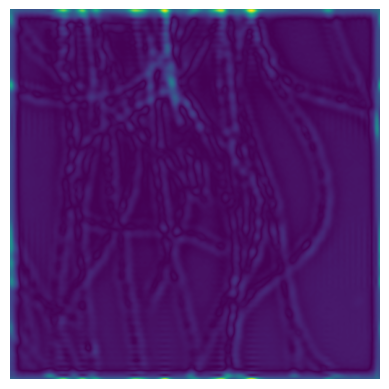

<Figure size 640x480 with 0 Axes>

In [5]:
# @title Create Error Map GUI
gui_error = EasyGui("Error")

import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt
from nanopyx.core.transform import ErrorMap


def run_error(b):
    clear_output()
    gui_error.show()
    gui_error.save_settings()
    gui_error["run"].disabled = True
    gui_error["run"].description = "Calculating..."
    global errormap
    error_map = ErrorMap()
    error_map.optimise(
        np.mean(dataset_original, axis=0), np.mean(dataset_esrrf, axis=0)
    )
    gui_error["run"].disabled = False
    gui_error["run"].description = "Calculate"
    print("RSE: ", error_map.getRSE())
    print("RSP: ", error_map.getRSP())
    errormap = np.array(error_map.imRSE)
    if gui_error["save"].value:
        if own_data:
            path = gui_data["upload"].selected_path
            name = gui_data["upload"].selected_filename.split(".")[0]
            tiff.imwrite(path + os.sep + name + "_error_map.tif", errormap)
        else:
            name = gui_data["data_source"].value.replace(
                "Example dataset: ", ""
            )
            tiff.imwrite(name + "_error_map.tif", errormap)
    plt.imshow(errormap)
    plt.axis("off")
    img_buf = io.BytesIO()
    plt.savefig(img_buf, format="jpeg")
    output_plot = widgets.Output()
    with output_plot:
        display(Image.open(img_buf))
    gui_error._main_display.children = gui_error._main_display.children + (
        widgets.Label(value="RSE: " + str(error_map.getRSE())),
        widgets.Label(value="RSP: " + str(error_map.getRSP())),
        output_plot,
    )
    plt.clf()


def run_error_stack(b):
    clear_output()
    gui_error.show()
    gui_error.save_settings()
    gui_error["run"].disabled = True
    gui_error["run"].description = "Calculating..."

    global errormap_stack, rse_rsp_table
    global dataset_original, dataset_esrrf
    errormap_stack = []
    rse_rsp_table = []

    # Ensure datasets are 3D
    if np.ndim(dataset_original) == 2:
        dataset_original = np.expand_dims(dataset_original, axis=0)
    if np.ndim(dataset_esrrf) == 2:
        dataset_esrrf = np.expand_dims(dataset_esrrf, axis=0)

    # Ensures datasets have same number of frames

    if dataset_original.shape[0] > dataset_esrrf.shape[0]:
        factor = dataset_original.shape[0] // dataset_esrrf.shape[0]
        remainder = dataset_original.shape[0] % dataset_esrrf.shape[0]
        averaged_blocks = [
            np.mean(dataset_original[i * factor : (i + 1) * factor], axis=0)
            for i in range(dataset_esrrf.shape[0])
        ]
        if remainder > 0:
            averaged_blocks.append(
                np.mean(dataset_original[-remainder:], axis=0)
            )
        dataset_original = np.array(averaged_blocks)

    # Iterate through each slice
    print("Processing slices...")
    for i in tqdm(range(dataset_original.shape[0]), desc="Slices processed"):
        slice_df = dataset_original[i]  #
        slice_sr = dataset_esrrf[i]  #

        error_map = ErrorMap()
        error_map.optimise(slice_df, slice_sr)

        # Store the error map and RSE/RSP values
        errormap_stack.append(np.array(error_map.imRSE))
        rse_rsp_table.append(
            {"Slice": i, "RSE": error_map.getRSE(), "RSP": error_map.getRSP()}
        )

    # Convert results to arrays
    errormap_stack = np.array(errormap_stack)  # 3D stack of error maps
    rse_rsp_table = pd.DataFrame(rse_rsp_table)  # Tabular results
    # Save error map stack as .tif and RSE/RSP table to CSV if required
    if gui_error["save"].value:
        if own_data:
            path = gui_data["upload"].selected_path
            name = gui_data["upload"].selected_filename.split(".")[0]
            tiff.imwrite(
                path + os.sep + name + "_error_map_stack.tif", errormap_stack
            )
            rse_rsp_table.to_csv(
                path + os.sep + name + "_rse_rsp_table.csv", index=False
            )
        else:
            name = gui_data["data_source"].value.replace(
                "Example dataset: ", ""
            )
            tiff.imwrite(name + "_error_map_stack.tif", errormap_stack)
            rse_rsp_table.to_csv(name + "_rse_rsp_table.csv", index=False)

    gui_error["run"].disabled = False
    gui_error["run"].description = "Calculate"

    # Display summary
    print("Calculation completed for all slices.")
    display(rse_rsp_table)
    plt.imshow(errormap_stack.mean(axis=0))  # Show mean error map
    plt.axis("off")
    plt.show()
    plt.clf()


gui_error.add_checkbox("save", description="Save output", value=True)
gui_error.add_dropdown(
    "cmaps",
    description="Colormap:",
    options=sorted(list(mpl.colormaps)),
    value="viridis",
    remember_value=True,
)
gui_error.add_button("run", description="Calculate")
gui_error["run"].on_click(run_error_stack)
gui_error.show()




## Calculate FRC resolution of the diffraction limited image
# FRC Parameters:

- **Pixel Size:** Pixel size of the image. Used to calculte resolution values.
- **Units:** Pixel size units.
- **First/Second Frame:** As FRC is calculated between two frames of the same image stack, these parameters determines which two frames are used for the calculation.




In [6]:
#@title create FRC GUI for original image
gui_frc = EasyGui("FRC")

import numpy as np
from nanopyx.core.analysis.frc import FIRECalculator

def run_frc(b):
    clear_output()
    gui_frc.show()
    gui_frc.save_settings()
    pixel_size = gui_frc["pixel_size"].value
    units = gui_frc["units"].value
    first_frame = gui_frc["first_frame"].value
    second_frame = gui_frc["second_frame"].value
    gui_frc["run"].disabled = True
    gui_frc["run"].description = "Calculating..."
    global frc_calculator_raw
    frc_calculator_raw = FIRECalculator(pixel_size=pixel_size, units=units)
    frc_calculator_raw.calculate_fire_number(dataset_original[first_frame], dataset_original[second_frame])
    gui_frc["run"].disabled = False
    gui_frc["run"].description = "Calculate"
    plot = frc_calculator_raw.plot_frc_curve()
    if gui_frc["save"].value:
        if own_data:
            path = gui_data["upload"].selected_path
            name = gui_data["upload"].selected_filename.split(".")[0]
            tiff.imwrite(path + os.sep + name + "_original_FRC.tif", plot)
        else:
            name = gui_data["data_source"].value.replace("Example dataset: ", "")
            tiff.imwrite(name + "_FRC_df.tif", plot)
    plt.imshow(plot)
    plt.axis("off")
    img_buf = io.BytesIO()
    plt.savefig(img_buf, format="jpeg")
    output_plot = widgets.Output()
    with output_plot:
        display(Image.open(img_buf))
    gui_frc._main_display.children = gui_frc._main_display.children + (output_plot,)
    plt.clf()
    
gui_frc.add_int_slider("pixel_size", description="Pixel Size:", min=0.01, max=1000, value=100)
gui_frc.add_dropdown("units", description="Units: ", options=["nm", "um", "mm"], value="nm")
gui_frc.add_int_slider("first_frame", description="First Frame:", min=0, max=dataset_original[0].shape[0]-1, value=0)
gui_frc.add_int_slider ("second_frame", description="Second Frame:", min=0, max=dataset_original[0].shape[0]-1, value=1)
gui_frc.add_checkbox("save", description="Save Output", value=True)
gui_frc.add_button("run", description="Calculate")
gui_frc["run"].on_click(run_frc)
gui_frc.show()




<Figure size 640x480 with 0 Axes>

## Calculate FRC resolution of the SR image
# FRC Parameters:

- **Pixel Size:** Pixel size of the image. Used to calculte resolution values.
- **Units:** Pixel size units.
- **First/Second Frame:** As FRC is calculated between two frames of the same image stack, these parameters determines which two frames are used for the calculation.




In [7]:
#@title create FRC GUI for SR image
gui_frc_esrrf = EasyGui("FRC")

import numpy as np
from nanopyx.core.analysis.frc import FIRECalculator

def run_frc(b):
    clear_output()
    gui_frc_esrrf.show()
    gui_frc_esrrf.save_settings()
    pixel_size = gui_frc_esrrf["pixel_size"].value
    units = gui_frc_esrrf["units"].value
    first_frame = gui_frc_esrrf["first_frame"].value
    second_frame = gui_frc_esrrf["second_frame"].value
    gui_frc_esrrf["run"].disabled = True
    gui_frc_esrrf["run"].description = "Calculating..."
    global frc_calculator_raw
    frc_calculator_raw = FIRECalculator(pixel_size=pixel_size, units=units)
    frc_calculator_raw.calculate_fire_number(dataset_esrrf[first_frame], dataset_esrrf[second_frame])
    gui_frc_esrrf["run"].disabled = False
    gui_frc_esrrf["run"].description = "Calculate"
    plot = frc_calculator_raw.plot_frc_curve()
    if gui_frc_esrrf["save"].value:
        if own_data:
            path = gui_data["upload"].selected_path
            name = gui_data["upload"].selected_filename.split(".")[0]
            tiff.imwrite(path + os.sep + name + "_original_FRC.tif", plot)
        else:
            name = gui_data["data_source"].value.replace("Example dataset: ", "")
            tiff.imwrite(name + "_FRC_df.tif", plot)
    plt.imshow(plot)
    plt.axis("off")
    img_buf = io.BytesIO()
    plt.savefig(img_buf, format="jpeg")
    output_plot = widgets.Output()
    with output_plot:
        display(Image.open(img_buf))
    gui_frc_esrrf._main_display.children = gui_frc_esrrf._main_display.children + (output_plot,)
    plt.clf()
    
gui_frc_esrrf.add_int_slider("pixel_size", description="Pixel Size:", min=0.01, max=1000, value=100)
gui_frc_esrrf.add_dropdown("units", description="Units: ", options=["nm", "um", "mm"], value="nm")
gui_frc_esrrf.add_int_slider("first_frame", description="First Frame:", min=0, max=dataset_esrrf[0].shape[0]-1, value=0)
gui_frc_esrrf.add_int_slider ("second_frame", description="Second Frame:", min=0, max=dataset_esrrf[0].shape[0]-1, value=1)
gui_frc_esrrf.add_checkbox("save", description="Save Output", value=True)
gui_frc_esrrf.add_button("run", description="Calculate")
gui_frc_esrrf["run"].on_click(run_frc)
gui_frc_esrrf.show()




<Figure size 640x480 with 0 Axes>

## Calculate Decorrelation analysis resolution of the diffraction limited image
# Image Decorrelation Analysis Parameters:

- **Pixel Size:** Pixel size of the image. Used to calculte resolution values.
- **Units:** Pixel size units.
- **Frame:** Frame to be used for decorrelation analysis
- **Radius Min/Max:** Resolution calculation by Decorrelation Analysis is performed in the frequency space. These parameters define the range of radii to be used in the calculation. 




In [8]:
#@title Create Decorrelation Analysis GUI for eSRRF data
gui_decorr = EasyGui("DecorrAnalysis")

from nanopyx.core.analysis.decorr import DecorrAnalysis

def run_decorr(b):
    clear_output()
    gui_decorr.show()
    gui_decorr.save_settings()
    pixel_size = gui_decorr["pixel_size"].value
    units = gui_decorr["units"].value
    first_frame = gui_decorr["first_frame"].value
    rmin = gui_decorr["rmin"].value
    rmax = gui_decorr["rmax"].value
    gui_decorr["run"].disabled = True
    gui_decorr["run"].description = "Calculating..."
    global decorr_calculator
    decorr_calculator = DecorrAnalysis(pixel_size=pixel_size, units=units, rmin=rmin, rmax=rmax)
    decorr_calculator.run_analysis(dataset_original[first_frame])
    gui_decorr["run"].disabled = False
    gui_decorr["run"].description = "Calculate"
    plot = decorr_calculator.plot_results()
    if gui_decorr["save"].value:
        if own_data:
            path = gui_data["upload"].selected_path
            name = gui_data["upload"].selected_filename.split(".")[0]
            tiff.imwrite(path + os.sep + name + "_eSRRF_decorr_analysis.tif", plot)
        else:
            name = gui_data["data_source"].value.replace("Example dataset: ", "")
            tiff.imwrite(name + "_eSRRF_decorr_analysis.tif", plot)
    plt.imshow(plot)
    plt.axis("off")
    img_buf = io.BytesIO()
    plt.savefig(img_buf, format="jpeg")
    output_plot = widgets.Output()
    with output_plot:
        display(Image.open(img_buf))
    gui_decorr._main_display.children = gui_decorr._main_display.children + (output_plot,)
    plt.clf()

gui_decorr.add_int_slider("pixel_size", description="Pixel Size:", min=0.01, max=1000, value=100)
gui_decorr.add_dropdown("units", description="Units: ", options=["nm", "um", "mm"], value="nm")
gui_decorr.add_int_slider("first_frame", description="Frame to be used:", min=0, max=dataset_original.shape[0]-1, value=0)
gui_decorr.add_float_slider("rmin", description="Radius Min:", min=0.0, max=0.5, value=0.0)
gui_decorr.add_float_slider("rmax", description="Radius Max:", min=0.5, max=1.0, value=1.0)
gui_decorr.add_checkbox("save", description="Save Output", value=True)
gui_decorr.add_button("run", description="Calculate")
gui_decorr["run"].on_click(run_decorr)
gui_decorr.show()




<Figure size 640x480 with 0 Axes>

## Calculate Decorrelation analysis resolution of the SR image
# Image Decorrelation Analysis Parameters:

- **Pixel Size:** Pixel size of the image. Used to calculte resolution values.
- **Units:** Pixel size units.
- **Frame:** Frame to be used for decorrelation analysis
- **Radius Min/Max:** Resolution calculation by Decorrelation Analysis is performed in the frequency space. These parameters define the range of radii to be used in the calculation. 




In [9]:
#@title Create Decorrelation Analysis GUI for eSRRF data
gui_decorr_esrrf = EasyGui("DecorrAnalysis")

from nanopyx.core.analysis.decorr import DecorrAnalysis

def run_decorr(b):
    clear_output()
    gui_decorr_esrrf.show()
    gui_decorr_esrrf.save_settings()
    pixel_size = gui_decorr_esrrf["pixel_size"].value
    units = gui_decorr_esrrf["units"].value
    first_frame = gui_decorr_esrrf["first_frame"].value
    rmin = gui_decorr_esrrf["rmin"].value
    rmax = gui_decorr_esrrf["rmax"].value
    gui_decorr_esrrf["run"].disabled = True
    gui_decorr_esrrf["run"].description = "Calculating..."
    global decorr_calculator
    decorr_calculator = DecorrAnalysis(pixel_size=pixel_size, units=units, rmin=rmin, rmax=rmax)
    decorr_calculator.run_analysis(dataset_esrrf[first_frame])
    gui_decorr_esrrf["run"].disabled = False
    gui_decorr_esrrf["run"].description = "Calculate"
    plot = decorr_calculator.plot_results()
    if gui_decorr_esrrf["save"].value:
        if own_data:
            path = gui_data["upload"].selected_path
            name = gui_data["upload"].selected_filename.split(".")[0]
            tiff.imwrite(path + os.sep + name + "_eSRRF_decorr_analysis.tif", plot)
        else:
            name = gui_data["data_source"].value.replace("Example dataset: ", "")
            tiff.imwrite(name + "_eSRRF_decorr_analysis.tif", plot)
    plt.imshow(plot)
    plt.axis("off")
    img_buf = io.BytesIO()
    plt.savefig(img_buf, format="jpeg")
    output_plot = widgets.Output()
    with output_plot:
        display(Image.open(img_buf))
    gui_decorr_esrrf._main_display.children = gui_decorr_esrrf._main_display.children + (output_plot,)
    plt.clf()

gui_decorr_esrrf.add_int_slider("pixel_size", description="Pixel Size:", min=0.01, max=1000, value=100)
gui_decorr_esrrf.add_dropdown("units", description="Units: ", options=["nm", "um", "mm"], value="nm")
gui_decorr_esrrf.add_int_slider("first_frame", description="Frame to be used:", min=0, max=dataset_esrrf.shape[0]-1, value=0)
gui_decorr_esrrf.add_float_slider("rmin", description="Radius Min:", min=0.0, max=0.5, value=0.0)
gui_decorr_esrrf.add_float_slider("rmax", description="Radius Max:", min=0.5, max=1.0, value=1.0)
gui_decorr_esrrf.add_checkbox("save", description="Save Output", value=True)
gui_decorr_esrrf.add_button("run", description="Calculate")
gui_decorr_esrrf["run"].on_click(run_decorr)
gui_decorr_esrrf.show()



<Figure size 640x480 with 0 Axes>